### Solid Waste Engineering 2018
#### Book 2 of x see notebook Solid Waste Engineering 2018
#### Semester project: Testing the probability of garbage
Masters students in Environmental Engineering from the [École Polytechnique Féderale de Lausanne](https://enac.epfl.ch/environmental-engineering) test the hypothesis that litter densities on Lac Léman are predicatable.  The current method is based on the Probability Density Function derived from the logarithm of the pieces/meter of trash (pcs/m) from over 100 samples.

#### Purpose: Understanding how the results from one inventory relate to the rest of the inventories for the lake.

1. Getting data from the API
2. Reporting descriptive statistics
3. Comparing results on the lake
4. Graphing results

We will add to this workbook as the semester advances

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import seaborn
import requests
import json

### Get the data from the API

1. Change the value of the following variables to get analysis
2. Save the workbook with the name of the beach in the title

The api makes this operation very straight forward it can be put into a dataFrame directly.

### Step one define what body of water and what beach we want to compare

1. A complete list of lakes and rivers is available [here](https://mwshovel.pythonanywhere.com/dirt/beach_litter.html)
2. Click "list of lakes and rivers"
3. To see the list of MLW codes select the button "Inventory of All items" on the same page
4. Replace the values below
5. Use the browser menu above and select "cell" => "Run all"

In [2]:
lakeRiverName = "Lac-Léman"
beachName = "Tiger-duck-beach"
objectOfInterest = "G91"

In [3]:
# this will retrieve all the aggregated totals for each survey on the given body of water
# this is used to compare the overall results per beach - all items included
def createDailyTotals(aName):
    a = "http://mwshovel.pythonanywhere.com/dirt/daily-total/" + str(aName) + "/?format=json"
    return a
# this will retrieve all the non-agregated results per-beach/per-day
# this is used to compare the results for inidividual objects/items per beach or lake
def createCodeDf(aName):
    a = "https://mwshovel.pythonanywhere.com/dirt/codes/" + str(aName) + "/?format=json"
    return a
# this will get the information for all the beaches on the lake or river:
allLakeRiverBeaches = "http://mwshovel.pythonanywhere.com/dirt/beaches/" + str(lakeRiverName) + "/?format=json"

### Step two define the functions that get and treat the data

In [4]:
# This function will take the urls-make the API call and turn into dataframe
# and it checks that the dataframe that is returned has has data!
def getData(url):
    a = url
    try:
        c = requests.get(url).json()
    except ValueError:
        print("The name you provided is not listd in the database. You can find the current list of all lakes, rivers and beaches at https://mwshovel.pythonanywhere.com/dirt/beach_litter.html")
    d = pd.DataFrame(c)
    if d.empty == True:
        raise ValueError('The dataframe is empty check the beach-name or lake-river name')            
    else:
        return d

# This function will retireve the code definitions from the web-site
# and verifies that the code given by the user is valid
def codes():
    csvUrl = "https://mwshovel.pythonanywhere.com/static/newCriteria.csv"
    a = pd.read_csv(csvUrl)
    b = list(a.code.unique())
    if objectOfInterest in b:
        return a
    else:
        raise ValueError("The code is not included in the current list. Check to see that you entered it correctly ie.. 'G89'")

# This will return only the data from the desired beach:
# and verifies that the beach given is included with the given lake or river
def beachDf(beachData, beachName):
    a = list(beachData.location_id.unique())
    if beachName in a:
        b = beachData.loc[beachData.location_id == beachName].copy()
    else:
        raise ValueError('The beach is not included with the river or lake that was chosen. You can find the current list of all lakes, rivers and beaches at https://mwshovel.pythonanywhere.com/dirt/beach_litter.html')
    return b

# This will return the list of codes identified in a df and the number of codes identified
def codeFrequency(df):
    a = list(df.code_id)
    b = len(a)
    return a, b

# This will make a column of pcs_m for the dataFrame
def pcs_m(df):
    df['pcs_m'] = df.quantity/df.length
    return df

# This will remove any records with a pcs/m value of Zero
def greaterThanZero(df):
    df = df[df['pcs_m'] > 0]
    return df.copy()

# This creates a log column of the pcs/m value from a df
def logOfPcsMeter(df):
    df['ln_pcs'] = np.log(df['pcs_m'])
    return df.copy()
    
# This will create a list of objects from a beach that are greater than the percentile specified:
def getGreaterThan(aList, df, aBeach, p):
    c = []
    
    for b in aList:
        a = df.loc[df.code_id == b ][['location_id','code_id', 'pcs_m']]
        e = a.pcs_m.quantile(p)
        f = a[(a.location_id == aBeach) & (a.pcs_m > e)]
        # grab the value that is greater than the desired %
        if len(f['pcs_m'].values) > 0:
            c.append((b,e,f['pcs_m'].values[0]))
    return c
# This will print a string for the values from the getGreaterThan
def whatsMyPercentile(aList, p):
    a = "There were " + str(len(aList)) + " categories greater than the " + str(p) + "th %,"
    return a
# This returns a list of the codes from the getGreaterThan:
def codesListPercent(aList):
    a = [x[0] for x in aList]
    return a
# returns the number of entries in a df used for the number of samples 
def numSamples(df):
    a = len(df)
    return a

### Step three functions that create the charts:

In [5]:
# code to make histogram:
def makeHist(df, numSamps):
    a = pd.DataFrame(df['quantity'].groupby([df['location_id'],df['date'], df['code_id']]).sum())
    b = a.groupby(['location_id', 'date']).count()
    fig = plt.gcf()
    g = seaborn.distplot(b, bins=9, kde=False, rug=True);
    g.set_ylabel("Number of surveys", labelpad= 10, color='b', fontsize=14)
    g.set_xlabel('Number of categories indentified', labelpad= 10, color='b', fontsize=14)
    g.set_title("Number of categories per survey n=" + str(numSamps), color='b', fontsize=14)
# code to make the chart:
def boxPlots99(df, dfBeach, aList):
    a = list(dfBeach.code_id)
    b = df.loc[df.code_id.isin(a)]
    theNinetyNine = b.loc[b.code_id.isin(aList)]
    # use the log otherwise the scale is way out their
    ax = seaborn.boxplot(x="code_id", y="ln_pcs", palette=random_colors, data=theNinetyNine)
    fig = plt.gcf()
    y_tick_labels = []
    seaborn.despine(offset=10)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    for label in ax.get_yticks():
        label = round(np.exp(label), 2)
        y_tick_labels.append(label)
    ax.set_yticklabels(y_tick_labels)
    ax.set_ylabel("Pcs/m log scale", labelpad= 10, color='b', fontsize=14)
    ax.set_xlabel('MLW Code', labelpad= 10, color='b', fontsize=14)
    ax.set_title("Distribution of the categories in the 99%", color='b', fontsize=14)
    fig.set_size_inches(8,5)
    plt.show()
    
def stripPlot99(df, dfBeach, aList):
    a = list(dfBeach.code_id)
    b = df.loc[df.code_id.isin(a)]
    
    theNinetyNine = b.loc[b.code_id.isin(aList)]
    c = len(theNinetyNine)
    g = seaborn.catplot(x="code_id", y="ln_pcs", data=theNinetyNine, aspect=1,hue="location_id", s=8,
                        palette=random_colors, legend_out=False,)
    # set the figure
    fig = plt.gcf()
    # move the chart off the grid lines a little
    seaborn.despine(offset=10)
    # need to convert the y tick labels from log(x) to e^x
    y_tick_labels = []
    for ax in g.axes.flat:
        # rotate the xtick labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)
        # convert the ytick labels
        for label in ax.get_yticks():
            label = round(np.exp(label), 2)
            y_tick_labels.append(label)
    ax.set_yticklabels(y_tick_labels)
    # set the axis labels
    g.ax.set_ylabel("Pcs/m log scale", labelpad= 10, color='b', fontsize=14)
    g.ax.set_xlabel('MLW Code', labelpad= 10, color='b', fontsize=14)
    g.ax.set_title("Distribution of the categories in the 99%, n=" + str(c), color='b', fontsize=14)
    fig.set_size_inches(8, 8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lg = plt.gcf().legend(title='Beaches')
    lg.get_title().set_fontsize(14)
    plt.show()

def stripPlotAll(df, aList):
    
    b = df.loc[df.code_id.isin(aList)]
    g = seaborn.catplot(x="code_id", y="ln_pcs", data=b, aspect=1,hue="location_id",
                        s=8, edgecolor="w", palette=random_colors, jitter=True, legend_out=False,)
    fig = plt.gcf()
    y_tick_labels = []
    seaborn.despine(offset=10)
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
        for label in ax.get_yticks():
            label = round(np.exp(label), 2)
            y_tick_labels.append(label)
        ax.set_yticklabels(y_tick_labels)
    g.ax.set_ylabel("Pcs/m log scale", labelpad= 10, color='b', fontsize=14)
    g.ax.set_xlabel('MLW Code', labelpad= 10, color='b', fontsize=14)
    g.ax.set_title("Distribution of MLW codes indentified all surveys n=" + str(numSamps),
                   color='b', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lg = plt.gcf().legend(title='Beaches')
    lg.get_title().set_fontsize(14)
    fig.set_size_inches(11, 8)
    plt.show()
# boxplot code for object of interest
def oOiBoxplot():
    ax = seaborn.boxplot( palette=random_colors, orient='h', data=oOI[["pcs_m", "code_id"]])
    ax.set_xlabel("Media-filters-(G91) per meter", labelpad= 10, color='b', fontsize=14)
    ax.set_ylabel("Media-filters-(G91)", labelpad= 10, color='b', fontsize=14)
    ax.set_title("Media-filters indentified all surveys n=" + str(numb), color='b', fontsize=14)
def oOiStripPlot():
    g = seaborn.catplot(x="code_id", y="pcs_m", data=oOI, 
                        aspect=1,hue="location_id", palette=random_colors, s=10, legend_out=False,)
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    g.ax.set_ylabel(str(objectOfInterest) + " per meter", labelpad= 10, color='b', fontsize=14)
    g.ax.set_xlabel(str(objectOfInterest), labelpad= 10, color='b', fontsize=14)
    g.ax.set_title(str(objectOfInterest) + " indentified all surveys n=" + str(numb), color='b', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lg = plt.gcf().legend(title='Beaches')
    lg.get_title().set_fontsize(14)
    fig.set_size_inches(6, 8)
    plt.show()

def randomColors(n):
    xkcd_colors = list(seaborn.xkcd_rgb.keys())
    these_colors =  np.random.choice(xkcd_colors, 34, replace=False)
    random_colors = seaborn.xkcd_palette(these_colors)
    return random_colors

def codeDefinition(aList):
    a = mlwCodes.loc[mlwCodes.code.isin(crazy99)]
    for n, row in a.iterrows():
        thisRow = row[['code', 'description', 'material', 'source']].values
        print(str(thisRow[0]) + ": " + str(thisRow[1]) + ", " + str(thisRow[2]) + ", source: " +str(thisRow[3]))

    

### Step four name the variables and format the data to make the charts

In [6]:
# creating the different outputs for the chart fucntions
lakeCodeData =getData(createCodeDf(lakeRiverName))
lakeDailyTotal = getData(createDailyTotals(lakeRiverName))
thisBeachCode = beachDf(lakeCodeData, beachName)
lakeCodePcsM = pcs_m(lakeCodeData)
beachCodePcsM = pcs_m(lakeCodeData)
logbeachCodePcsM = logOfPcsMeter(greaterThanZero(beachCodePcsM))
loglakeCodePcsM = logOfPcsMeter(greaterThanZero(lakeCodePcsM))
mlwCodes = codes()

numSamps = numSamples(lakeDailyTotal)

### Step five create charts and discuss results
### How many MLW codes were identified at this beach?

1. What are those codes

In [7]:
# The list of codes indentified:
listOfCodes, numberOfCodes = codeFrequency(thisBeachCode)
print(listOfCodes)

['G200', 'G178', 'G70', 'G28', 'G34', 'G24', 'G21', 'G23', 'G32', 'G125', 'G95', 'G89', 'G27', 'G93', 'G31', 'G35', 'G124', 'G91', 'G67', 'G30', 'G100', 'G137', 'G82', 'G96', 'G87', 'G138', 'G50', 'G161', 'G98', 'G79']


In [8]:
# The number of codes indentified:
print("There were " + str(numberOfCodes) + " categories indentified at " +  str(beachName) + ".")

There were 30 categories indentified at Tiger-duck-beach.


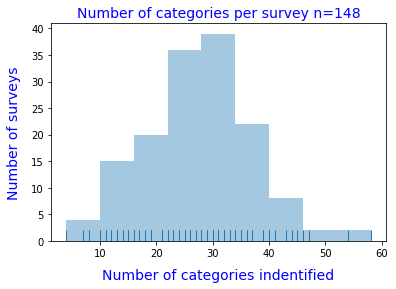

In [9]:
makeHist(lakeCodeData, numSamps)

### How does the number of categories found at this beach compare to the results for the entire lake or river?


In [10]:
# enter your reply here.


### What items found could be considered extreme values for this lake or river

1. Third quartile or greater when compared to all other results on the lake?
2. Were there any objects that could be considered true outliers (greater than the 99th %)

In [11]:
# defining the percentiles
def getPercentiles(aList):
    c = []
    for x in aList:
        a = getGreaterThan(listOfCodes, greaterThanZero(lakeCodePcsM), beachName, x)
        c.append(a)
        b = whatsMyPercentile(a, int(x*100))
        print(b)
    return c
ninetyNinth = getPercentiles([.75, .95, .99])

There were 25 categories greater than the 75th %,
There were 19 categories greater than the 95th %,
There were 9 categories greater than the 99th %,


In [12]:
# The outliers for this survey, when compared to the rest of the lake:
crazy99 = [x[0] for x in ninetyNinth[2]]
print(crazy99)

['G24', 'G21', 'G32', 'G89', 'G93', 'G100', 'G137', 'G87', 'G79']


### How would you describe the results of the box plot of the or these obects in the 99th percentile ? 

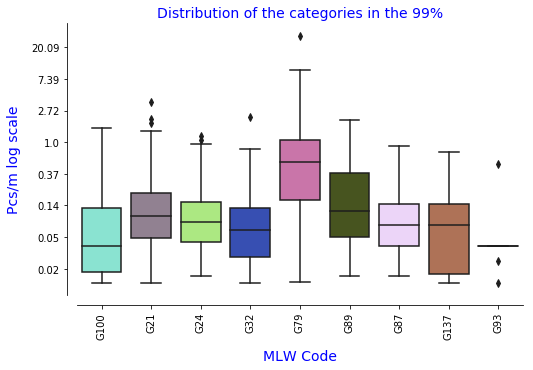

In [13]:
# Get some colors for box plot
random_colors = randomColors(34)
# Box plot of the objects in the 99th percentile 
boxPlots99(loglakeCodePcsM, logbeachCodePcsM, crazy99)

In [14]:
# your reply here

### What are the items in the 99th %?

1. Description, material, source?

In [15]:
codeDefinition(crazy99)

G21: Drink lids, Plastic, source: Food
G24: Plastic rings from lids, Plastic, source: Food
G32: Toys and fireworks, Plastic, source: Recreation
G79: Plastic pieces 2.5 > < 50cm, Plastic, source: Fragmented
G87: Masking tape, Plastic, source: Construction
G89: Plastic construction waste, Plastic, source: Construction
G93: Cable ties , Plastic, source: Construction
G100: Medical containers, Plastic, source: Medical
G137: Clothing, rags, hats etc.,,, Cloth, source: Personal effects


#### Do you agree with the source as listed above?

1. How would you calssify the source of these objects?

### This is the same data as the box plots, sometimes the distribtution is easier to understand like this :

1. Each occurence for the code is represented in one vertical strip
2. Color is the beach where it was found
3. n = the total number of times the codes were identified

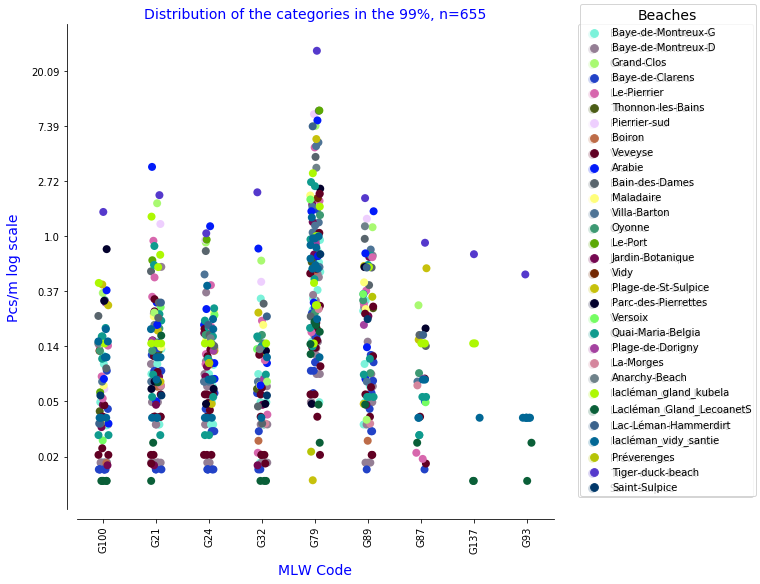

In [16]:
stripPlot99(loglakeCodePcsM, logbeachCodePcsM, crazy99)

### Here is the strip plot of all the codes found at the selected beach and the same codes at all other beaches on the lake

1. What can we say about the distribution of objects found in relation to the rest of lake?
2. Which Items do you think you are most likeley to find in general?
3. How does the object source play a role in the distribtution?
4. Do you think these objects were deposited at the beach? How did they get there?

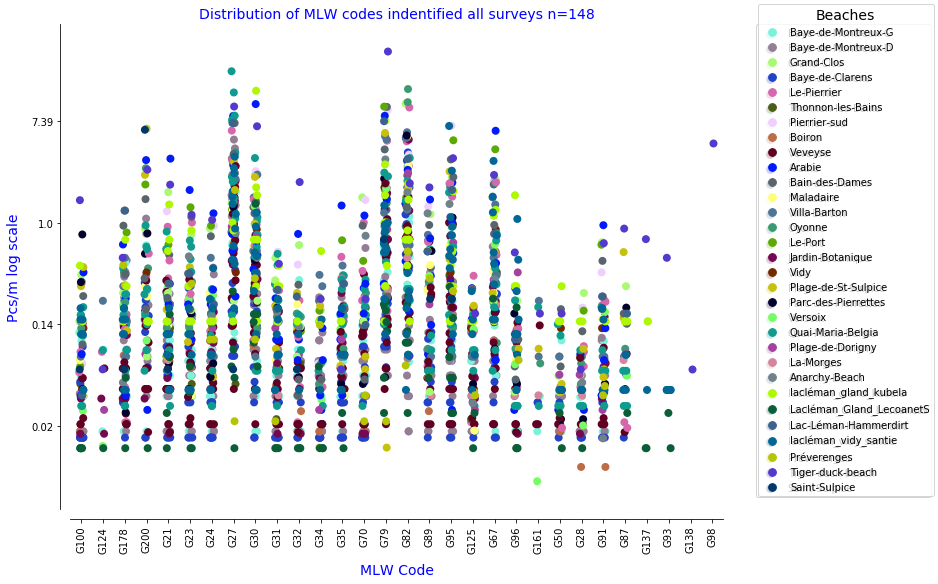

In [17]:
stripPlotAll(loglakeCodePcsM, listOfCodes)

### Object of interest  rankings and quantity

1. How many were found ?
2. What is the ranking in relation to the other beaches?
3. What is the frequency of identification, are they found at every survey ?

In [18]:
# percentile ranking and frquency of media filters
oOI = lakeCodePcsM [lakeCodePcsM .code_id == objectOfInterest].copy()
oOI['POF']  = oOI['pcs_m'].apply(lambda x: scipy.stats.percentileofscore(oOI['pcs_m'], x, kind='weak'))
score = oOI[oOI.location_id == beachName]["POF"]
found = oOI[oOI.location_id == beachName]["quantity"]
numb = len(oOI)

if found.size > 0:
    print("There were " + str(found.values[0]) + " media-filters found, or " + str(round(found.values[0]/18, 2)) + " pcs/m.")
    print("The media filters pcs/m ranking at " + beachName + " is in the " + str(round(score.values[0], 0)) + " percentile of " + str(numb) + " samples.")
    print("There are " + str(len(lakeDailyTotal)) + " samples currently in the data-base, so they are found about 50% of the time.")
else:
    print("The object of interest was not found at this beach")
    

There were 12 media-filters found, or 0.67 pcs/m.
The media filters pcs/m ranking at Tiger-duck-beach is in the 97.0 percentile of 73 samples.
There are 148 samples currently in the data-base, so they are found about 50% of the time.


### Boxplot of the object of interest

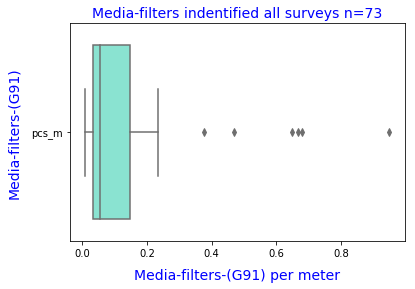

In [19]:
if found.size > 0:
    oOiBoxplot()
else:
    print("Nothing to plot")

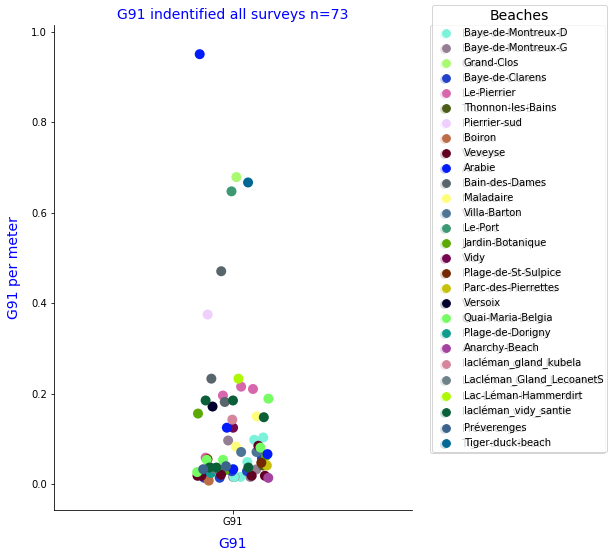

In [20]:
if found.size > 0:
    oOiStripPlot()
else:
     print("Nothing to plot")